# Growth rate estimates

Code to read in information per country on total number of cases and number of days since case 100
Then to fit the data, obtaining the date of inflection and the initial growth rate

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import csv
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import pandas 
from datetime import date

%matplotlib inline

In [2]:
#Fit functions
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def linear_fit(x,m,c):
    return x*m + c

In [3]:
#Calculate chi-squared goodness of fit
def chisquare(data,expct):
    return sum((data-expct)**2 / expct)

In [148]:
#Function to find the number of days between two dates
def days_diff(date1,date2):
    
    d1info = date1.split("-")
    d2info = date2.split("-")
    d1 = date(int(d1info[0]), int(d1info[1]), int(d1info[2]))
    d2 = date(int(d2info[0]),int(d2info[1]),int(d2info[2]))
    delta = d2 - d1
    
    return(delta.days)

In [149]:
#Function to obtain growth rate from data file
#Input: 
# inputfile = days since 100 cases , total number of cases, csv format
# country = name of country of interest
# daterange = boolean : option for a user specified range of days
# interventiondate = "YYYY-MM-DD" date of intervention
def ObtainGrowthRate(inputfile,country,daterange=False,interventiondate="2000-01-01"):
    
    #initialise date range
    daystart=0
    dayend=100
    #Read in data file 
    df = pandas.read_csv(inputfile)
    
    date100 = df[country][df["Days since 100"] == daystart]
    
    #Find intervention date in days after day of case 100
    if not isinstance(date100[0],np.float64):
        inter_date = days_diff(date100[0],interventiondate)
   
    
    #Define date range to fit. Default = all days
    mask = np.ones(len(df["Days since 100"])-1,dtype=bool)
    daymask = (df["Days since 100"] > daystart) 

    #copy to a list for same length
    days100 = df["Days since 100"][daymask]
    
    #Now case remaining information to integers
    cases100 = list(map(float,df[country][daymask]))
    cases100 = np.array(cases100)
    mask = mask & np.logical_not(np.isnan(cases100))
   
    if not sum(mask):
        print("Insufficient data for",country)
        return 0., 0., 0.
    
    #Mask to only consider days with data
    dayend = days100[np.argmax(cases100)]
    mask = mask & (days100 < dayend) & (cases100 > 0.)

    #Adjust if date range is specified
    if daterange:
        mask = (days100 > daystart) & (days100 < dayend)
    
    #Check for sufficient data points:
    if len(cases100[mask]) < 5:
        print("Insufficient data for",country)
        return 0., 0., 0.
    
    #Perform a linear fit to the data
    popt, pcov = curve_fit(linear_fit, days100[mask],np.log10(cases100[mask]))
    chi2 = chisquare(cases100[mask],10.**(days100[mask]*popt[0] + popt[1]))

    inflection_date = 0.
    logchi2 = 0
    #Need minimum number of approx. ten days for a logistic fit
    if len(days100[mask]) > 15.:
        #Perform a logistic fit to the data
        try:
            log_fit, log_cov = curve_fit(logistic_model,days100[mask],cases100[mask],
                                 p0=[2.5,1,max(cases100[mask])],maxfev=1200)
            logchi2 = chisquare(cases100[mask],logistic_model(days100[mask],*log_fit))
            
            inflection_date = log_fit[1]
        except RuntimeError:
            print("Logistic function fit failed for",country)
            
            
    if ((chi2 < logchi2) or (inflection_date > max(days100[mask])) or not inflection_date) and not (inter_date > 5):
        growthrate = popt[0]
        print("linear fit preferred for",country,"growth rate",growthrate)
        return growthrate, 0., inflection_date

    if (logchi2 < chi2) and (inflection_date < max(days100[mask])):
        print("logistic fit preferred for",country)
        print("inflection date",inflection_date)
    
        #Alternatively, calculate pre and post intervention date:
    if inter_date > 5.:
        mask1 = mask & (days100 < inter_date)
        mask2 = mask & (days100 > inter_date)
    else:
        #Perform linear fits pre and post inflection date to compare growth rates
        mask1 = mask & (days100 < inflection_date)
        mask2 = mask & (days100 > inflection_date)


    growthrate = 0.
    growthrate2 = 0.
    
    #Check for sufficient data points:
    if sum(mask1) > 5:
        popt, pcov = curve_fit(linear_fit, days100[mask1],np.log10(cases100[mask1]))
        chi2 = chisquare(cases100[mask1],10.**(days100[mask1]*popt[0] + popt[1]))
        growthrate = popt[0]
    
    if sum(mask2) > 5:
        popt2, pcov2 = curve_fit(linear_fit, days100[mask2],np.log10(cases100[mask2]))
        chi2_2 = chisquare(cases100[mask2],10.**(days100[mask2]*popt2[0] + popt2[1]))
        growthrate2 = popt2[0]
        
    if inter_date > 5:
        print("intervention date",inter_date)
        return growthrate, growthrate2, inter_date
    
    return growthrate, growthrate2, inflection_date
    

In [150]:
ObtainGrowthRate("OneStepAhead/DataProcessing/CountryCasesFromHopkins.csv","United Kingdom",True,"2020-03-17")

intervention date 12


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


(0.09738872119443152, 0.08457548145128661, 12)

## List of countries

Now investigate the growth rates in a user-defined list of countries and write to file

In [157]:
#Read in countries from file 
def WriteGrowthRates(country_file,growthrate_file):
    
    gr1 = []
    gr2 = []
    dc = []
    
    data = pandas.read_csv(country_file)
    #print(data.columns[0])
    
    csvname = growthrate_file

    with open(csvname,mode='w') as growthrate_file:
        csv_writer = csv.DictWriter(growthrate_file,fieldnames=["Country","GrowthRate1","GrowthRate2","DayOfChange"])
        #country_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writeheader()
    
        cid = 1
        while cid < len(data.columns):
            growthrate = ObtainGrowthRate(country_file,data.columns[cid])
            print("Growth rate for",data.columns[cid],"is",growthrate[0])
            csv_writer.writerow({"Country":data.columns[cid],"GrowthRate1":format(growthrate[0],'.5g'),
                                "GrowthRate2":format(growthrate[1],'.5g'),"DayOfChange":format(growthrate[2],'.5g')})
            gr1.append(growthrate[0])
            gr2.append(growthrate[1])
            dc.append(growthrate[2])
            cid += 1
            
    #Also return the growth rate information
    growthrateinfo = data.columns,gr1,gr2,dc
    return growthrateinfo

In [158]:
grinfo = WriteGrowthRates("OneStepAhead/DataProcessing/CountryCasesFromHopkins.csv","GrowthRatesAll2.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


Insufficient data for Afghanistan
Growth rate for Afghanistan is 0.0
linear fit preferred for Albania growth rate 0.0572052664307372
Growth rate for Albania is 0.0572052664307372
linear fit preferred for Algeria growth rate 0.06914453954494737
Growth rate for Algeria is 0.06914453954494737
linear fit preferred for Andorra growth rate 0.07311215107413982
Growth rate for Andorra is 0.07311215107413982
Insufficient data for Angola
Growth rate for Angola is 0.0
Insufficient data for Antigua and Barbuda
Growth rate for Antigua and Barbuda is 0.0
linear fit preferred for Argentina growth rate 0.08836199595724586
Growth rate for Argentina is 0.08836199595724586
linear fit preferred for Armenia growth rate 0.056657709265897575
Growth rate for Armenia is 0.056657709265897575
logistic fit preferred for Australia
inflection date 18.045768128147095
Growth rate for Australia is 0.09101405058755094
logistic fit preferred for Austria
inflection date 18.647889292192843
Growth rate for Austria is 0.104

Growth rate for Libya is 0.0
Insufficient data for Liechtenstein
Growth rate for Liechtenstein is 0.0
linear fit preferred for Lithuania growth rate 0.07421662294545606
Growth rate for Lithuania is 0.07421662294545606
linear fit preferred for Luxembourg growth rate 0.09688537703746493
Growth rate for Luxembourg is 0.09688537703746493
Insufficient data for MS Zaandam
Growth rate for MS Zaandam is 0.0
Insufficient data for Madagascar
Growth rate for Madagascar is 0.0
logistic fit preferred for Malaysia
inflection date 14.780133590033959
Growth rate for Malaysia is 0.09169875614514716
Insufficient data for Maldives
Growth rate for Maldives is 0.0
Insufficient data for Mali
Growth rate for Mali is 0.0
linear fit preferred for Malta growth rate 0.02972553962612634
Growth rate for Malta is 0.02972553962612634
Insufficient data for Mauritania
Growth rate for Mauritania is 0.0
Insufficient data for Mauritius
Growth rate for Mauritius is 0.0
linear fit preferred for Mexico growth rate 0.0815347

Mean initial growth rate 0.0742632602396388
Mean second growth rate 0.017080185500871023
Growth rate ratio [0.03354872 0.04073636 0.36285653 0.05951768 0.41960092        inf]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


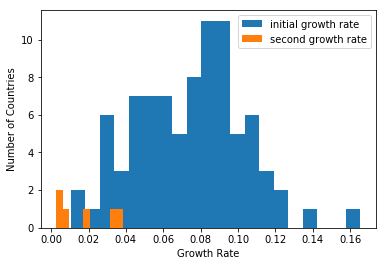

In [156]:
gr1 = np.array(grinfo[1])
gr2 = np.array(grinfo[2])

plt.hist(gr1[gr1>0],bins=20,label="initial growth rate")
plt.hist(gr2[gr2>0],label="second growth rate")
plt.legend()
plt.xlabel("Growth Rate")
plt.ylabel("Number of Countries")
print("Mean initial growth rate",np.mean(gr1[gr1>0]))
print("Mean second growth rate",np.mean(gr2[gr2>0]))
print("Growth rate ratio",gr2[gr2>0]/gr1[gr2>0])
#plt.savefig("InitialGrowthRateDistribution.png")

## Growth Rate pre- and post- Intervention

In this section, we obtain dates on which interventions were introduced and investigate changes in growth rates

In [318]:
#Function to read in interventions and investigate

def intervention_analysis(datefile,country_file):

    df = pandas.read_csv(datefile)
    
    gr_ratios = np.zeros(df.shape)
    num_ratios = np.zeros(df.shape[1])
    
    inter_types = []
    itt = 0
    for col in df.columns:
        if not (col=="Country") and itt % 2:
            inter_types.append(col)
        itt += 1
    print(inter_types)
    
    for row in df.iterrows():
        cnt = 0 # counter
        country = row[1][0]
        for column in row[1]:
            if not cnt:
                print(country)
            elif cnt % 2:
                flag = int(column)
            elif flag:
                date = column
                print("Obtaining Growth rate for",country,date)
                igr = ObtainGrowthRate(country_file,country,True,date)
                print("Intervention Date",date,"growth rate before=",igr[0],"growth rate after = ",igr[1])
                
                if igr[0] and igr[1]:
                    gr_ratios[row[0]][cnt] = igr[1]/igr[0]
                    num_ratios[cnt] += 1
                    
            cnt += 1
            
    #meanratios = np.mean(gr_ratios.T)
    
    it = 0
    mean_ratio_values = []
    num_ratio_values = []
    min_ratio_values = []
    max_ratio_values = []
    while it < len(num_ratios):
        if it and not it % 2:
            mean_ratio_values.append(np.mean(gr_ratios.T[it]))
            num_ratio_values.append(num_ratios[it])
            min_ratio_values.append(min(gr_ratios.T[it][gr_ratios.T[it]>0]))
            max_ratio_values.append(max(gr_ratios.T[it]))
        it += 1
            
    
    return inter_types, mean_ratio_values, num_ratio_values, min_ratio_values, max_ratio_values

In [319]:
ratios = intervention_analysis("OneStepAhead/DataProcessing/InterventionAndDate.csv","OneStepAhead/DataProcessing/CountryCasesFromHopkins.csv")


['Travel Ban/border lockdown', 'National emergency declared', 'Public transportation shutdown', 'School closures', 'Work closures/stay at home orders', 'Closure of non-essentials (stores, resto, cine, etc)', 'Mass Quarantine of sick', 'Internal Lockdown/curfew.quarantine of geographic area (city, state, region, province,etc.)', 'Door to door health checks', 'building and street sterilization', 'Mass test and treat']
China
Obtaining Growth rate for China 2020-01-23
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2020-01-23 growth rate before= 0.11314158502794369 growth rate after =  0.003795755813433055
Obtaining Growth rate for China 2020-01-21
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2020-01-21 growth rate before= 0.11314158502794369 growth rate after =  0.003795755813433055
Obtaining Growth rate for China 2020-01-23
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2020

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


0.003795755813433055
Obtaining Growth rate for China 2019-12-31
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2019-12-31 growth rate before= 0.11314158502794369 growth rate after =  0.003795755813433055
Obtaining Growth rate for China 2020-01-23
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2020-01-23 growth rate before= 0.11314158502794369 growth rate after =  0.003795755813433055
Obtaining Growth rate for China 2020-01-23
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2020-01-23 growth rate before= 0.11314158502794369 growth rate after =  0.003795755813433055
Obtaining Growth rate for China 2020-01-24
logistic fit preferred for China
inflection date 18.78489846885549
Intervention Date 2020-01-24 growth rate before= 0.11314158502794369 growth rate after =  0.003795755813433055
Obtaining Growth rate for China 2020-10-23
logistic fit preferred for China
inflection date 18.

## Ranked list of most effective interventions

Interventions are now ranked according to the most effective measures introduced (inducing the largest change in the most countries)

In [337]:
#Print output on intervention measures
ratios = np.array(ratios)
ranked = np.sort(ratios[1,:])
itn = 0
print("Intervention, average growth rate ratio, No. countries")
xi = []
yi = []
yilowerr = []
yiuperr = []
while itn < len(ranked):
    idx = list(ratios[1]).index(ranked[itn])
    
    print(itn+1,ratios[0][idx],ranked[itn],ratios[2][idx],"min ratio",ratios[3][idx],"max ratio",ratios[4][idx])
    if float(ratios[2][idx]) > 1:
        yi.append(float(ranked[itn]))
        yilowerr.append(float(ranked[itn])-float(ratios[3][idx]))
        yiuperr.append(float(ratios[4][idx])-float(ranked[itn]))
        xi.append(itn)
    itn += 1
        

Intervention, average growth rate ratio, No. countries
1 Public transportation shutdown 0.0022365816025973592 1.0 min ratio 0.033548724038960386 max ratio 0.033548724038960386
2 Door to door health checks 0.002725434992594855 1.0 min ratio 0.04088152488892283 max ratio 0.04088152488892283
3 Mass test and treat 0.006204427059883161 2.0 min ratio 0.033548724038960386 max ratio 0.05951768185928702
4 Mass Quarantine of sick 0.032475996496394204 2.0 min ratio 0.033548724038960386 max ratio 0.4535912234069527
5 Internal Lockdown/curfew.quarantine of geographic area (city, state, region, province,etc.) 0.12876648185803552 3.0 min ratio 0.3628565283096412 max ratio 0.8355381714847723
6 building and street sterilization 0.1465535513091369 5.0 min ratio 0.06228927845158109 max ratio 0.8498486140407514
7 National emergency declared 0.16896909767153295 5.0 min ratio 0.033548724038960386 max ratio 0.9558624248666109
8 Work closures/stay at home orders 0.17809986073980796 5.0 min ratio 0.03354872403

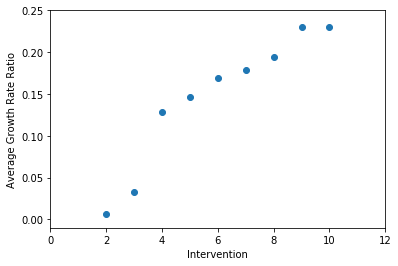

In [339]:
#plt.errorbar(xi,yi,yerr=[yilowerr,yiuperr],fmt="o")
plt.plot(xi,yi,"o")
plt.xlabel("Intervention")
plt.xlim(0,12)
plt.ylim(-0.01,0.25)
plt.ylabel("Average Growth Rate Ratio")
#plt.savefig("Interventions.png")